In [5]:
import os

import numpy as np
from sklearn.neural_network import BernoulliRBM

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

np.random.seed(0)

data_dir = "./data"
print(f"Data resides in        : {data_dir}")

Data resides in        : ./data


In [6]:
def z_meas_to_binary(line: str) -> np.ndarray:
    binary_array = [c == "Z" for c in line.strip()]
    return np.array(binary_array, dtype=np.float32).reshape(-1)

data_file = os.path.join(data_dir, "w_vanilla_20_20000.txt")

with open(data_file) as f:
    data = np.stack([z_meas_to_binary(l) for l in f])

print(f"Loaded {len(data)} samples, each of length {data.shape[1]} into numpy array of type {data.dtype}.")

num_train_samples = 20_000

idx = np.random.choice(data.shape[0], num_train_samples, replace=False)
data_subset = data[idx]

print(f"Subset shape: {data_subset.shape}")

Loaded 20000 samples, each of length 20 into numpy array of type float32.
Subset shape: (20000, 20)


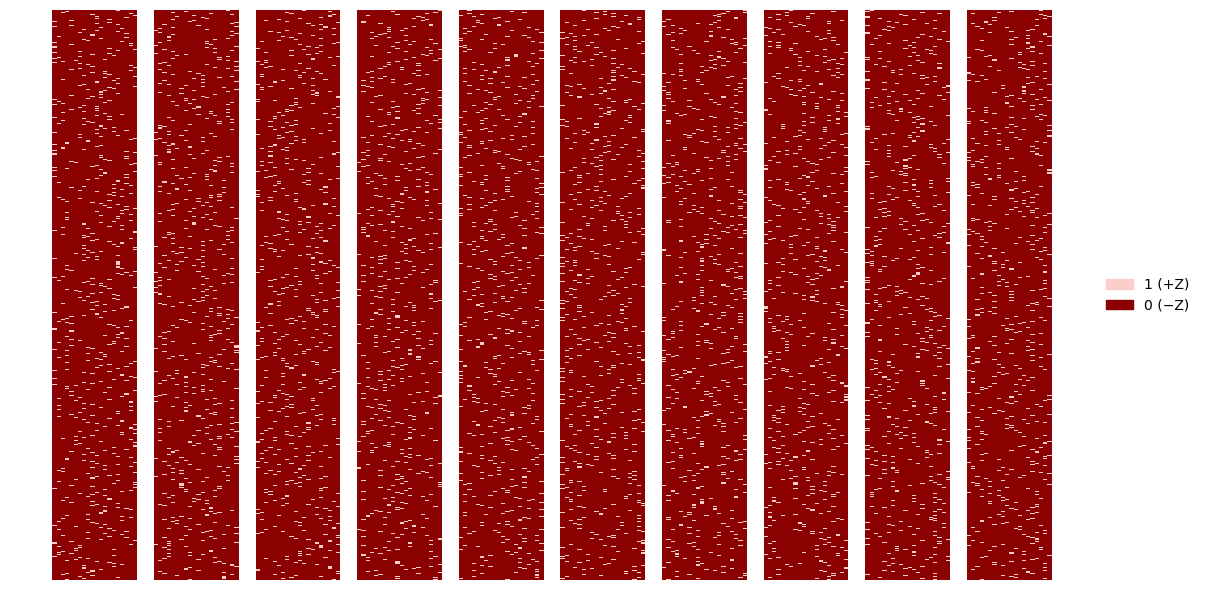

In [7]:
cols = 10
rows = data_subset.shape[0] // cols
panel_width = data_subset.shape[1]
spacer = 4
left_padding = 10
right_padding = 10

canvas_width = (left_padding + cols * panel_width + (cols - 1) * spacer + right_padding)

bright_red = "darkred"
dark_red = "#ffcccc"
flip_red_cmap = ListedColormap([bright_red, dark_red])
flip_red_cmap.set_bad("white")

canvas = np.full((rows, canvas_width), np.nan, dtype=np.float32)
for i in range(cols):
    start_x = left_padding + i * (panel_width + spacer)
    block = data_subset[i * rows:(i + 1) * rows, :]
    canvas[:, start_x:start_x + panel_width] = block

plt.figure(figsize=(12, 6))
img = plt.imshow(canvas, cmap=flip_red_cmap, interpolation='nearest', aspect='auto')
plt.axis('off')

dark_patch = mpatches.Patch(color=dark_red, label="1 (+Z)")
bright_patch = mpatches.Patch(color=bright_red, label="0 (−Z)")
plt.legend(
    handles=[dark_patch, bright_patch],
    loc="center right",
    bbox_to_anchor=(1.1, 0.5),
    frameon=False
)

plt.tight_layout()
plt.show()

In [12]:
rbm = BernoulliRBM(n_components=20,
                   learning_rate=0.01,
                   batch_size=100,
                   n_iter=50,
                   verbose=True,
                   random_state=0)

rbm.fit(data_subset)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -4.73, time = 0.02s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -4.28, time = 0.03s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -4.23, time = 0.03s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -4.22, time = 0.03s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -4.22, time = 0.02s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -4.22, time = 0.03s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -4.21, time = 0.03s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -4.21, time = 0.03s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -4.20, time = 0.03s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -4.20, time = 0.03s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -4.19, time = 0.03s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -4.19, time = 0.02s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -4.19, time = 0.03s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -4.18, time = 0.03s
[BernoulliRBM] Iteration 15, pseudo-likelih

BernoulliRBM(batch_size=100, learning_rate=0.01, n_components=20, n_iter=50,
             random_state=0, verbose=True)

In [13]:
def sample_rbm(rbm, n_fantasy=10_000, n_gibbs=200):
    v = np.random.rand(n_fantasy, rbm.n_features_in_) > 0.5
    for _ in range(n_gibbs):
        v = rbm.gibbs(v)
    return v.astype(int)

fantasy = sample_rbm(rbm)
rel_freq = fantasy.mean(0)
print(rel_freq)

[0.0532 0.0498 0.052  0.0508 0.0496 0.0569 0.0466 0.047  0.0516 0.0516
 0.0541 0.0561 0.0556 0.0506 0.0472 0.0509 0.0557 0.0526 0.0523 0.0502]


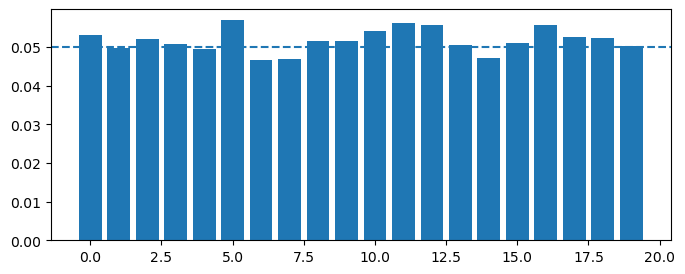

In [14]:
plt.figure(figsize=(8,3))
plt.bar(np.arange(20), rel_freq)
plt.axhline(1/20, ls='--')
plt.show()